In [100]:
import nltk
#nltk.download('cess_esp')
from nltk.corpus import cess_esp
from sklearn.model_selection import train_test_split, KFold
from nltk.tag import UnigramTagger,BigramTagger,hmm, tnt, AffixTagger,brill, brill_trainer, crf
from math import sqrt
from random import shuffle
import numpy as np
import pandas as pd
import math
from nltk.tag.perceptron import PerceptronTagger
import pycrfsuite

In [101]:
def accuracy95(p,ndatos):
    return 1.95*sqrt(p*(1-p) /ndatos)

def scuadrado(values):
    media = sum(values)/len(values)
    scuadrado = sum([(value-media)**2 for value in values]) / len(values)
    res = "[%.4f, %.4f]" %(media-scuadrado,media+scuadrado)
    return res

def scuadrado2(values):
    media = sum(values)/len(values)
    scuadrado = sum([(value-media)**2 for value in values]) / len(values)
    return round(media*100,2), round(scuadrado*100,2)

In [102]:
corpus = list(cess_esp.tagged_sents())

corpus_reducido = []
for frase in corpus:
    aux = []
    for palabra,categoria in frase:
        if palabra !="*0*":
            aux.append((palabra,categoria[0:3]) if categoria[0] == "v" or categoria[0] == "F" else (palabra,categoria[0:2]))
    corpus_reducido.append(aux)

corpus_barajado = corpus.copy()
corpus_reducido_barajado =corpus_reducido.copy()
shuffle(corpus_barajado)
shuffle(corpus_reducido_barajado)

globalResults = []
globalIC = []

# Tarea 1

In [103]:
def cross_validation(clasificador,k,datosParticionados):
    precisiones = []
    for i in range(k):
        train = datosParticionados.copy()
        test = train[i]
        del train[i]
        train = [val for sublist in train for val in sublist]#Aplano las listas de listas de listas
        tagger = clasificador.train(train[0:-1])
        precisiones.append(tagger.accuracy(test))
    return precisiones

def cross_validation_tnt(k,datosParticionados, n):
    precisiones = []
    if n > 0:
        for i in range(k):
            train = datosParticionados.copy()
            test = train[i]
            del train[i]
            train = [val for sublist in train for val in sublist]#Aplano las listas de listas de listas
            sufix_tagger = AffixTagger(train[0:-1], affix_length=-n)
            tagger = tnt.TnT(N=100, unk=sufix_tagger, Trained=True)
            tagger.train(train[0:-1])
            precisiones.append(tagger.accuracy(test))
    else:
        for i in range(k):
            train = datosParticionados.copy()
            test = train[i]
            del train[i]
            train = [val for sublist in train for val in sublist]#Aplano las listas de listas de listas
            tagger = tnt.TnT(N=100)
            tagger.train(train[0:-1])
            precisiones.append(tagger.accuracy(test))
    return precisiones

In [104]:
k = 10

corpus_part = [corpus_barajado[i*603 :i*603 +603] for i in range(k)]
corpus_reducido_part = [corpus_reducido_barajado[i*603 :i*603 +603] for i in range(k)]

tam_particion = [sum([len(frase) for frase in part]) for part in corpus_part]
tam_particion_reducido = [sum([len(frase) for frase in part]) for part in corpus_reducido_part]

precisiones_HMM_completo = cross_validation(hmm.HiddenMarkovModelTagger,10,corpus_part)
precision_HMM_reducido  = cross_validation(hmm.HiddenMarkovModelTagger,10,corpus_reducido_part)

intervalos_HMM_completo = [accuracy95(p,tam_particion[i]) for (i,p) in enumerate(precisiones_HMM_completo)]
intervalos_HMM_reducido = [accuracy95(p,tam_particion_reducido[i]) for (i,p) in enumerate(precision_HMM_reducido)]

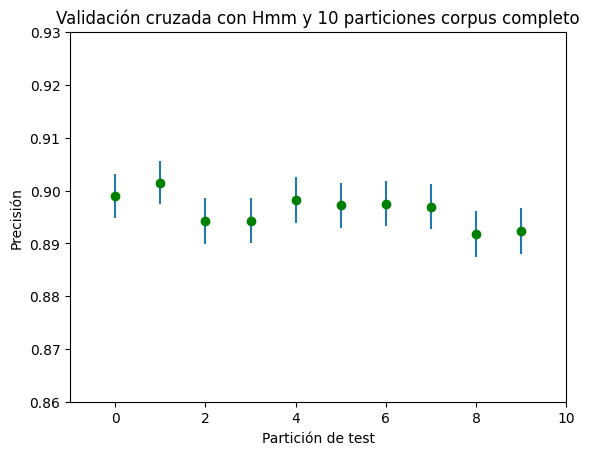

In [105]:
import matplotlib.pyplot as plt
x=[i for i in range(10)]
results=precisiones_HMM_completo
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.86, 0.93])
plt.ylabel('Precisión')
plt.xlabel('Partición de test')
plt.title('Validación cruzada con Hmm y 10 particiones corpus completo')
Tic=intervalos_HMM_completo# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.plot(x,y,'go')
plt.savefig("Tarea1.png",dpi=400)
plt.show()


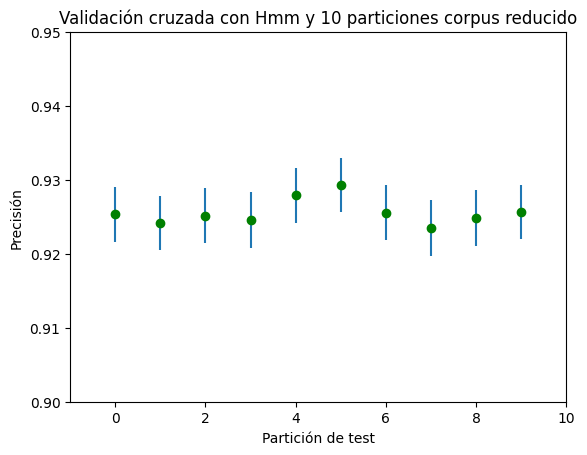

In [106]:
import matplotlib.pyplot as plt
x=[i for i in range(10)]
results=precision_HMM_reducido
y=results # results es una lista con los resultados de cada experimento
Tic=intervalos_HMM_reducido# Lista con los intervalos de confianza
globalResults.append(sum(y)/len(y))
globalIC.append(sum(Tic)/len(Tic))
plt.axis([-1, 10, 0.90, 0.95])
plt.ylabel('Precisión')
plt.xlabel('Partición de test')
plt.title('Validación cruzada con Hmm y 10 particiones corpus reducido')

plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.plot(x,y,'go')
plt.savefig("Tarea1b.png",dpi=400)
plt.show()


In [107]:
datos_corpus_completo = {"precicisiones":precisiones_HMM_completo,"intervalos":intervalos_HMM_completo }
datos_corpus_reducido = {"precicisiones":precision_HMM_reducido,"intervalos":intervalos_HMM_reducido }
df_completo = pd.DataFrame(datos_corpus_completo)
df_reducido = pd.DataFrame(datos_corpus_reducido)

In [108]:
df_completo = df_completo.reset_index()
df_completo.rename(columns={'index': 'particion'}, inplace=True)
print(df_completo)

   particion  precicisiones  intervalos
0          0       0.899001    0.004196
1          1       0.901504    0.004128
2          2       0.894265    0.004394
3          3       0.894278    0.004295
4          4       0.898214    0.004318
5          5       0.897174    0.004277
6          6       0.897514    0.004256
7          7       0.896950    0.004238
8          8       0.891803    0.004378
9          9       0.892372    0.004350


In [109]:
df_reducido = df_reducido.reset_index()
df_reducido.rename(columns={'index': 'particion'}, inplace=True)
print(df_reducido)

   particion  precicisiones  intervalos
0          0       0.925346    0.003678
1          1       0.924186    0.003704
2          2       0.925188    0.003745
3          3       0.924633    0.003786
4          4       0.927901    0.003705
5          5       0.929311    0.003642
6          6       0.925559    0.003735
7          7       0.923541    0.003788
8          8       0.924874    0.003767
9          9       0.925664    0.003688


# Tarea 2

In [110]:
test_completo = corpus_part[-1]
tam_part10_comp = sum([len(frase) for frase in test_completo])
acc_completo = []
intervalo_t2_comp = []
intervalo_t2_red = []
for i in range(1,len(corpus_part)):
    elTodo = corpus_part[0:i]
    trainCompleto = []
    for particion in elTodo:
        trainCompleto+=particion
    tagger = hmm.HiddenMarkovModelTagger.train(trainCompleto)
    precision = tagger.accuracy(test_completo) 
    acc_completo.append(precision)
    intervalo_t2_comp.append(accuracy95(precision,tam_part10_comp))

test_reducido = corpus_reducido_part[-1]
tam_part10_red = sum([len(frase) for frase in test_reducido])
acc_reducido = []
for i in range(1,len(corpus_reducido_part)):
    elTodo = corpus_reducido_part[0:i]
    trainCompleto = []
    for particion in elTodo:
        trainCompleto+=particion
    tagger = hmm.HiddenMarkovModelTagger.train(trainCompleto)
    precision = tagger.accuracy(test_reducido) 
    acc_reducido.append(precision)
    intervalo_t2_red.append(accuracy95(precision,tam_part10_red))



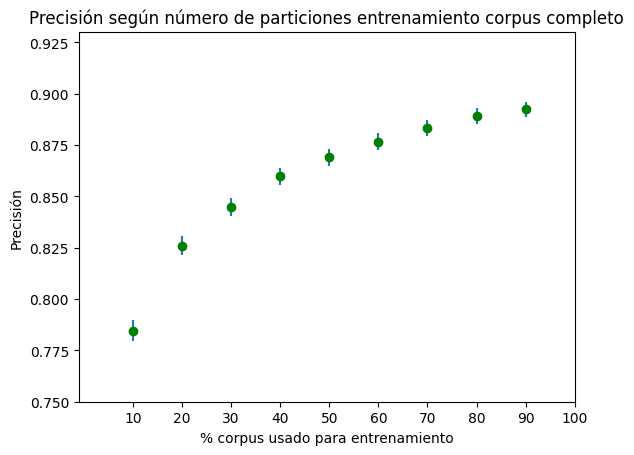

In [111]:
xticks=[i for i in range(10,110,10)]
x=xticks[:9]
y=acc_completo # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.75, 0.93])
plt.xticks(xticks)
plt.ylabel('Precisión')
plt.xlabel('% corpus usado para entrenamiento')
plt.title('Precisión según número de particiones entrenamiento corpus completo')
Tic=intervalo_t2_red# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.plot(x,y,'go')
plt.savefig("Tarea2a.png",dpi=400)
plt.show()

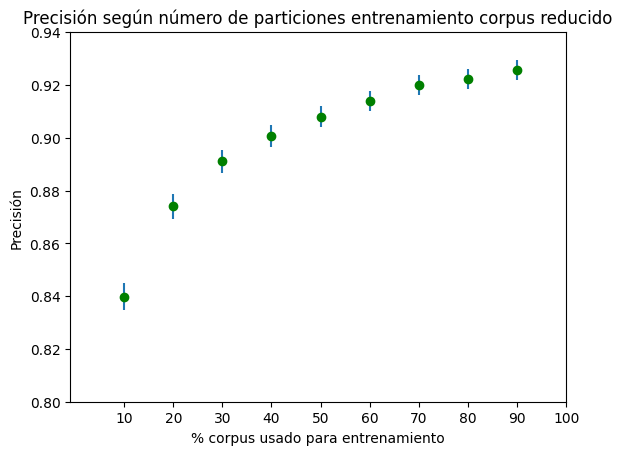

In [112]:
xticks=[i for i in range(10,110,10)]
x=xticks[:9]
y=acc_reducido # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.80, 0.94])
plt.xticks(xticks)
plt.ylabel('Precisión')
plt.xlabel('% corpus usado para entrenamiento')
plt.title('Precisión según número de particiones entrenamiento corpus reducido')
Tic=intervalo_t2_red# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.plot(x,y,'go')
plt.savefig("Tarea2b.png",dpi=400)
plt.show()

# Tarea 3

In [113]:
precisionesPorSufijo = []
intervalo_t3 = []
for lenSufix in range(1, 10):
    precisiones_TNT = []
    for i in range(10):
        train = corpus_reducido_part.copy()
        test = train[i]
        del train[i]
        train = [val for sublist in train for val in sublist] #aplanamos la lista
        sufix_tagger = AffixTagger(train, affix_length=-lenSufix)
        precisiones_TNT.append(sufix_tagger.accuracy(test))
    precisionesPorSufijo.append(precisiones_TNT)
    

precisionesMediaPorSufijo = [scuadrado2(precisiones) for precisiones in precisionesPorSufijo]
print(precisionesMediaPorSufijo)

[(24.45, 0.0), (28.25, 0.0), (29.55, 0.0), (26.48, 0.0), (22.56, 0.0), (16.48, 0.0), (11.34, 0.0), (7.5, 0.0), (4.79, 0.0)]


18880.3

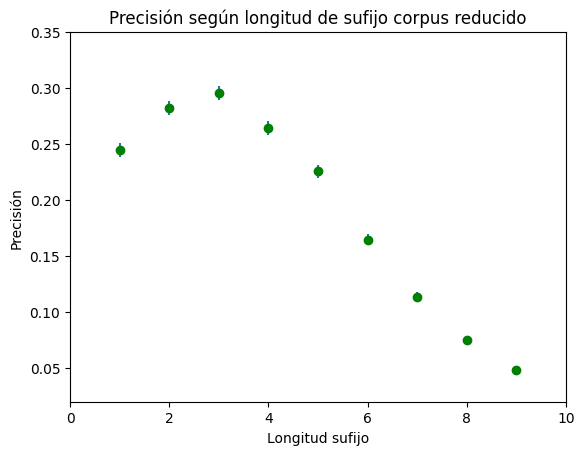

In [140]:
x=[i for i in range(1,10)]
results=[p/100 for p,q in precisionesMediaPorSufijo]
#print(results)
y=results # results es una lista con los resultados de cada experimento
plt.axis([-0, 10, 0.02, 0.35])
plt.ylabel('Precisión')
plt.xlabel('Longitud sufijo')
plt.title('Precisión según longitud de sufijo corpus reducido')
tam_medio_part = sum([sum([len(frase) for frase in part]) for part in corpus_reducido_part])/10
intervalos_t3 = [accuracy95(p,tam_medio_part) for (i,p) in enumerate(results)]
plt.errorbar(x,y,yerr=intervalos_t3,linestyle='None')
plt.plot(x,y, "go")
plt.savefig("Tarea3.png",dpi=400)
plt.show()

In [115]:

results_tnt_no_smooth = cross_validation_tnt(10, corpus_part, 0)
results_tnt_smooth = cross_validation_tnt(10, corpus_part, 3)

intervalos_TNT_no_smooth = [accuracy95(p,tam_particion[i]) for (i,p) in enumerate(results_tnt_no_smooth)]
intervalos_TNT_smooth = [accuracy95(p,tam_particion[i]) for (i,p) in enumerate(results_tnt_no_smooth)]

print("TnT sin suavizado", results_tnt_no_smooth)
globalResults.append(sum(results_tnt_no_smooth)/len(results_tnt_no_smooth))
globalIC.append(sum(intervalos_TNT_no_smooth)/len(intervalos_TNT_no_smooth))
print("TnT con suavizado(longitud de sufijo = 3)", results_tnt_smooth)
globalResults.append(sum(results_tnt_smooth)/len(results_tnt_smooth))
globalIC.append(sum(intervalos_TNT_smooth)/len(intervalos_TNT_smooth))




TnT sin suavizado [0.8924747629244417, 0.8974669492380664, 0.8922242508860487, 0.8948421862971516, 0.8948892583257361, 0.8988945666910001, 0.8961160020714656, 0.8946507944617585, 0.8928478135938561, 0.8950150274639859]
TnT con suavizado(longitud de sufijo = 3) [0.9342306515754053, 0.9348067413462509, 0.9327676941252282, 0.9340518347446753, 0.934305786453585, 0.9371154447804776, 0.9352667011910927, 0.9330199764982373, 0.9335980356303224, 0.9347600787646388]


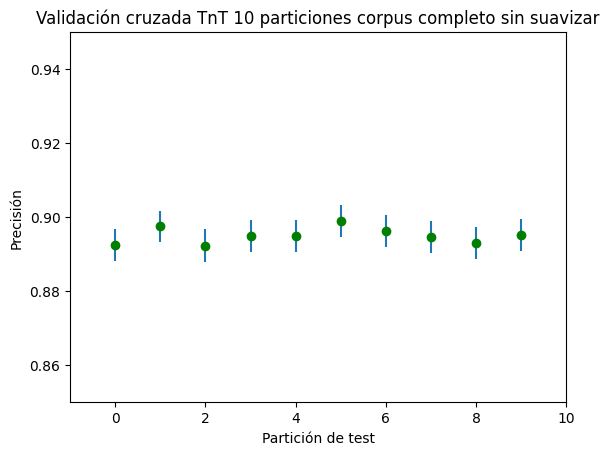

In [116]:
x=[i for i in range(10)]
results=results_tnt_no_smooth
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.85, 0.95])
plt.ylabel('Precisión')
plt.xlabel('Partición de test')
plt.title('Validación cruzada TnT 10 particiones corpus completo sin suavizar')
Tic=intervalos_TNT_no_smooth# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.plot(x,y,'go')
plt.savefig("Tarea3b.png",dpi=400)
plt.show()

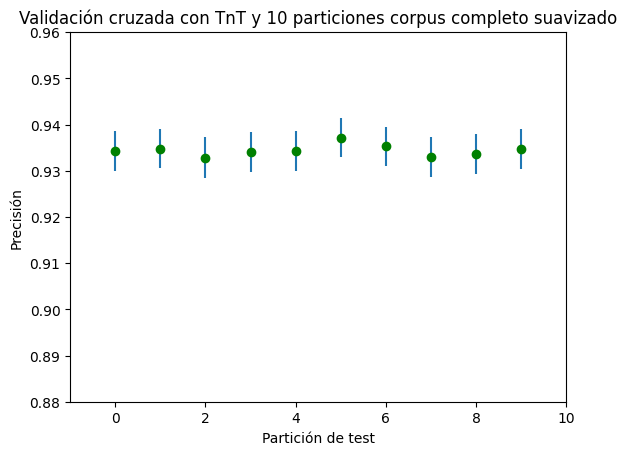

In [117]:
x=[i for i in range(10)]
results=results_tnt_smooth
y=results # results es una lista con los resultados de cada experimento
plt.axis([-1, 10, 0.88, 0.96])
plt.ylabel('Precisión')
plt.xlabel('Partición de test')
plt.title('Validación cruzada con TnT y 10 particiones corpus completo suavizado')
Tic=intervalos_TNT_smooth# Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.plot(x,y,'go')
plt.savefig("Tarea3c.png",dpi=400)
plt.show()

# Tarea 4

### Brill

In [118]:
lenCorpusTok = len(corpus_reducido_barajado)
train=corpus_reducido_barajado[:9*lenCorpusTok//10]
test=corpus_reducido_barajado[9*lenCorpusTok//10:]

acc = []
ic = []

tagger_unigramas = UnigramTagger(train)
brill.Template._cleartemplates()
templates = brill.fntbl37()
trainer = nltk.tag.brill_trainer.BrillTaggerTrainer(initial_tagger=tagger_unigramas,
                                   templates=templates, trace=3,
                                   deterministic=True)
tagger1 = trainer.train(train, max_rules=1000)
accBrill = tagger1.accuracy(test)
globalResults.append(accBrill)
icBrill = accuracy95(accBrill, lenCorpusTok)
globalIC.append(icBrill)
print("Precisión CRFTagger : ",accBrill)
print("Intervalo de confianza al 95%: ", icBrill)

TBL train (fast) (seqs: 5427; tokens: 169566; tpls: 37; min score: 2; min acc: None)
Finding initial useful rules...
    Found 105885 useful rules.

           B      |
   S   F   r   O  |        Score = Fixed - Broken
   c   i   o   t  |  R     Fixed = num tags changed incorrect -> correct
   o   x   k   h  |  u     Broken = num tags changed correct -> incorrect
   r   e   e   e  |  l     Other = num tags changed incorrect -> incorrect
   e   d   n   r  |  e
------------------+-------------------------------------------------------
10721213 141   0  | pr->cs if Pos:vmi@[-3,-2,-1]
 242 257  15   0  | da->pp if Pos:vmi@[1]
 195 290  95   0  | pr->cs if Word:que@[0] & Pos:sp@[-1]
 163 318 155  10  | nc->aq if Pos:nc@[-1]
 105 131  26   0  | pr->cs if Pos:vai@[-3,-2,-1]
 103 111   8   0  | aq->vmp if Pos:vai@[-1]
  95 110  15  11  | di->pi if Pos:sp@[1]
  82 127  45   1  | pr->cs if Pos:rg@[-2,-1]
  75  76   1   0  | pr->cs if Word:que@[0] & Pos:vmn@[-1]
  58  58   0   0  | pr->cs if Word

### CRF

In [119]:
tagger_crf = crf.CRFTagger()
tagger_crf.train(train, "model")
accCRF = tagger_crf.accuracy(test)
globalResults.append(accCRF)
icCRF = accuracy95(accCRF, lenCorpusTok)
globalIC.append(icCRF)
print("Precisión CRFTagger : ",accCRF)
print("Intervalo de confianza al 95%: ", icCRF)

Precisión CRFTagger :  0.9551385351146229
Intervalo de confianza al 95%:  0.005198114770659385


### Perceptron

In [120]:
pt = PerceptronTagger(load=False)
pt.train(train)
accPer = pt.accuracy(test)
globalResults.append(accPer)
icPer = accuracy95(accPer, lenCorpusTok)
globalIC.append(icPer)
print("Precisión PerceptronTagger : ",accPer)
print("Intervalo de confianza al 95%: ", icPer)

Precisión PerceptronTagger :  0.9689140718407236
Intervalo de confianza al 95%:  0.004358133267977071


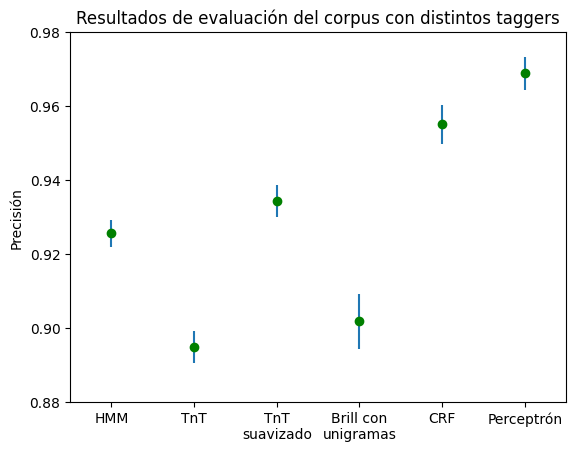

In [145]:
x=[i for i in range(6)]
labels = ["HMM", "TnT", "TnT\nsuavizado", "Brill con\nunigramas", "CRF", "Perceptrón"]
plt.xticks(x,labels)
y=globalResults # results es una lista con los resultados de cada experimento
plt.axis([-0.5, 5.5, 0.88, 0.98])
plt.ylabel('Precisión')
plt.title('Resultados de evaluación del corpus con distintos taggers')
Tic=globalIC # Lista con los intervalos de confianza
plt.errorbar(x,y,yerr=Tic,linestyle='None')
plt.plot(x,y,'go')

plt.savefig('Tarea4.png')
plt.show()

In [141]:
print(globalResults)
print(globalIC)

[0.9256203974742864, 0.8949421611953511, 0.9343922945109913, 0.9018038155637573, 0.9551385351146229, 0.9689140718407236]
[0.0037237975583732756, 0.004307921600012034, 0.004307921600012034, 0.007472730088119763, 0.005198114770659385, 0.004358133267977071]
